In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ensemble_stack.inference import *
from ensemble_stack.regression.data import load_mapper, one_hot_encode, Validation
from ensemble_stack.regression.models import *
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from sklearn.manifold import TSNE
import random
from sklearn.metrics import mean_squared_error

# Neural Network Results (Box Plots)

In [27]:
class Validation(Dataset):
    def __init__(self, lstm=False):
        raw_seqs = np.loadtxt('ensemble_stack/interpreter/data/Test set Regression/valid.tsv', dtype='str')[:, 1]
        enrichment = np.loadtxt('ensemble_stack/interpreter/data/Test set Regression/valid_target.txt')
        enrichment = enrichment.reshape(enrichment.shape[0], 1)
        mapper = load_mapper('ensemble_stack/interpreter/data/mapper')
        if lstm:
            self.x = torch.stack([one_hot_encode(seq, mapper) for seq in raw_seqs]).reshape(-1, 20, 20)
        else:
            self.x = torch.stack([one_hot_encode(seq, mapper) for seq in raw_seqs])
        self.y = torch.from_numpy(np.vstack([x for x in enrichment]))
        self.n_samples = len(raw_seqs)
        

    def __getitem__(self, index):
        return self.x[index].float(), self.y[index].float()

    def __len__(self):
        return self.n_samples

In [28]:
loaded_models = load_all_models()

In [91]:
output = []
mse = []
r_squared = []
pearson = []
gt_enrichment = np.loadtxt('ensemble_stack/interpreter/data/Test set Regression/valid_target.txt')
for idx, model in enumerate(loaded_models.values()):
    if idx > 17:
        dataset = DataLoader(Validation(lstm=True), batch_size=100)
    else:
        dataset = DataLoader(Validation(), batch_size=100)

    model.eval()

    predictions = []
    for step, data in enumerate(dataset):
        inputs, labels = data
        if idx <=17:
            inputs, labels = inputs.to(device), labels.to(device)
        out = model(inputs).flatten()

        predictions.append(out.tolist())

    predictions = np.concatenate(predictions)
    mse.append(mean_squared_error(gt_enrichment, predictions))
    r_squared.append(r2_score(gt_enrichment, predictions))
    pearson.append(pearsonr(gt_enrichment, predictions)[0])
# output = np.vstack(output)
# output = output.reshape(output.shape[0], output.shape[1]).T

In [92]:
raw_seqs = np.loadtxt('ensemble_stack/interpreter/data/Test set Regression/valid.tsv', dtype='str')[:, 1]
stacked_pred = get_stacked_prediction(raw_seqs).flatten()
stacked_r2 = r2_score(gt_enrichment, stacked_pred.detach().numpy())
stacked_pearson = pearsonr(gt_enrichment, stacked_pred.detach().numpy())
stacked_mse = mean_squared_error(gt_enrichment, stacked_pred.detach().numpy())

Text(6.800000000000004, 0.5, 'Mean Squared Error')

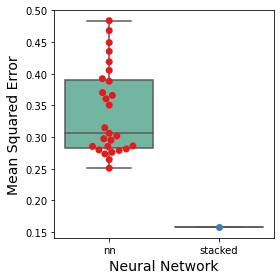

In [93]:
plt.figure(figsize=(4,4), tight_layout=True)

mse_df = pd.DataFrame(columns=['nn', 'stacked'])
mse_df['nn'] = mse
mse_df.loc[0, 'stacked'] = stacked_mse

ax = sns.boxplot(data=mse_df, palette='Set2', showfliers=False)
ax1 = sns.swarmplot(data=mse_df, palette='Set1', s=7)
ax1.set_xlabel("Neural Network", fontsize = 14)
ax1.set_ylabel("Mean Squared Error", fontsize = 14)

Text(6.800000000000004, 0.5, '$R^2$')

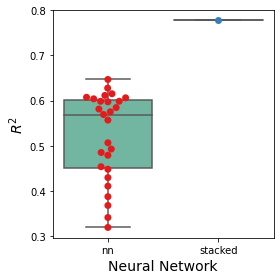

In [94]:
plt.figure(figsize=(4,4), tight_layout=True)

r2_df = pd.DataFrame(columns=['nn', 'stacked'])
r2_df['nn'] = r_squared
r2_df.loc[0, 'stacked'] = stacked_r2

ax = sns.boxplot(data=r2_df, palette='Set2', showfliers=False)
ax1 = sns.swarmplot(data=r2_df, palette='Set1', s=7)
ax1.set_xlabel("Neural Network", fontsize = 14)
ax1.set_ylabel("$R^2$", fontsize = 14)

Text(6.800000000000004, 0.5, 'Pearson R')

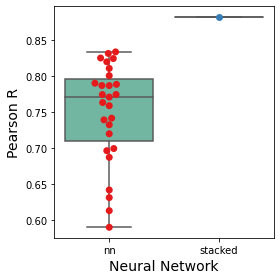

In [110]:
plt.figure(figsize=(4,4), tight_layout=True)

pearson_df = pd.DataFrame(columns=['nn', 'stacked'])
pearson_df['nn'] = pearson
pearson_df.loc[0, 'stacked'] = stacked_pearson[0]

ax = sns.boxplot(data=pearson_df, palette='Set2', showfliers=False)
ax1 = sns.swarmplot(data=pearson_df, palette='Set1', s=7)
ax1.set_xlabel("Neural Network", fontsize = 14)
ax1.set_ylabel("Pearson R", fontsize = 14)

# Stacked Prediction Scatterplot

In [98]:
enrichment = np.loadtxt('ensemble_stack/interpreter/data/Test set Regression/valid_target.txt')

<AxesSubplot:>

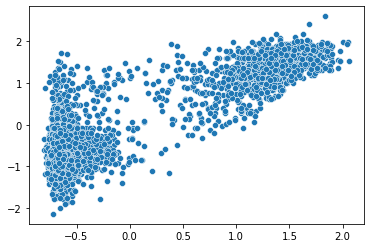

In [104]:
sns.scatterplot(x=stacked_pred.detach().numpy(), y=enrichment)

# TSNE Plot

In [3]:
enrichment_0 = pd.read_csv('graph_generation/data/generated/generation2_seqs/3eak_gen_0.tsv', sep='\t')['enrichment']
enrichment_1 = pd.read_csv('graph_generation/data/generated/generation2_seqs/3eak_gen_1.tsv', sep='\t')['enrichment']
enrichment_2 = pd.read_csv('graph_generation/data/generated/generation2_seqs/3eak_gen_2.tsv', sep='\t')['enrichment']
enrichment_3 = pd.read_csv('graph_generation/data/generated/generation2_seqs/3eak_gen_3.tsv', sep='\t')['enrichment']
enrichment_4 = pd.read_csv('graph_generation/data/generated/generation2_seqs/3eak_gen_4.tsv', sep='\t')['enrichment']

In [4]:
train_data = np.loadtxt('ensemble_stack/regression/data/Test set Regression/test.tsv', dtype='str')[:, 1]
# seq_4 = pd.read_csv('graph_generation/data/generated/generation2_seqs/3eak_gen_4.tsv', sep='\t')['cdr3']
# buffered = [seq.center(20, 'J') for seq in seq_4]
mapper = load_mapper('ensemble_stack/regression/data/mapper')
X_train = torch.stack([one_hot_encode(seq, mapper) for seq in train_data]).numpy()
Y_train = np.loadtxt('ensemble_stack/regression/data/Test set Regression/test_target.txt')
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=5000)
tsne_results = tsne.fit_transform(X_train.reshape((X_train.shape[0], 400)))
df = pd.DataFrame()
df['Enrichment'] = Y_train
df['t-SNE Component 1'] = tsne_results[:,0]
df['t-SNE Component 2'] = tsne_results[:,1]

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 22690 samples in 0.003s...
[t-SNE] Computed neighbors for 22690 samples in 14.867s...
[t-SNE] Computed conditional probabilities for sample 1000 / 22690
[t-SNE] Computed conditional probabilities for sample 2000 / 22690
[t-SNE] Computed conditional probabilities for sample 3000 / 22690
[t-SNE] Computed conditional probabilities for sample 4000 / 22690
[t-SNE] Computed conditional probabilities for sample 5000 / 22690
[t-SNE] Computed conditional probabilities for sample 6000 / 22690
[t-SNE] Computed conditional probabilities for sample 7000 / 22690
[t-SNE] Computed conditional probabilities for sample 8000 / 22690
[t-SNE] Computed conditional probabilities for sample 9000 / 22690
[t-SNE] Computed conditional probabilities for sample 10000 / 22690
[t-SNE] Computed conditional probabilities for sample 11000 / 22690
[t-SNE] Computed conditional probabilities for sample 12000 / 22690
[t-SNE] Computed conditional probabilities for s

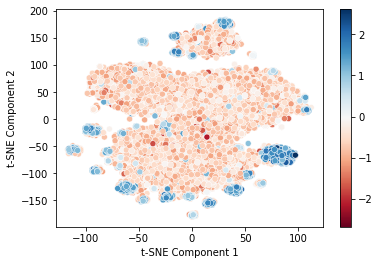

In [10]:
ax = sns.scatterplot(x="t-SNE Component 1", y="t-SNE Component 2", hue="Enrichment", palette="RdBu",
                data=df)

norm = plt.Normalize(df['Enrichment'].min(), df['Enrichment'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm)
plt.show()

# Iterative Refinement Results

<AxesSubplot:xlabel='enrichment', ylabel='Percent'>

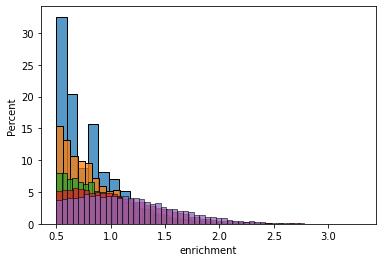

In [84]:
sns.histplot(enrichment_0, stat='percent')
sns.histplot(enrichment_1, stat='percent')
sns.histplot(enrichment_2, stat='percent')
sns.histplot(enrichment_3, stat='percent')
sns.histplot(enrichment_4, stat='percent')

In [85]:
ppl_0 = pd.read_csv('graph_generation/data/generated/generation2_seqs/3eak_gen_0.tsv', sep='\t')['perplexity']
ppl_1 = pd.read_csv('graph_generation/data/generated/generation2_seqs/3eak_gen_1.tsv', sep='\t')['perplexity']
ppl_2 = pd.read_csv('graph_generation/data/generated/generation2_seqs/3eak_gen_2.tsv', sep='\t')['perplexity']
ppl_3 = pd.read_csv('graph_generation/data/generated/generation2_seqs/3eak_gen_3.tsv', sep='\t')['perplexity']
ppl_4 = pd.read_csv('graph_generation/data/generated/generation2_seqs/3eak_gen_4.tsv', sep='\t')['perplexity']

<AxesSubplot:xlabel='perplexity', ylabel='Percent'>

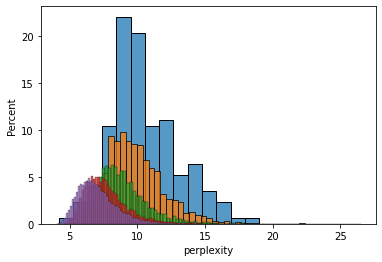

In [86]:
sns.histplot(ppl_0, stat='percent')
sns.histplot(ppl_1, stat='percent')
sns.histplot(ppl_2, stat='percent')
sns.histplot(ppl_3, stat='percent')
sns.histplot(ppl_4, stat='percent')

In [87]:
seqs = pd.read_csv('graph_generation/data/generated/generation2_seqs/3eak_gen_4.tsv', sep='\t')
seq_counts = {}

for seq in seqs.values:
    seq = seq[0]
    for char in seq:    
        if char in seq_counts:
            seq_counts[char] += 1
        else:
            seq_counts[char] =1

<AxesSubplot:xlabel='0', ylabel='1'>

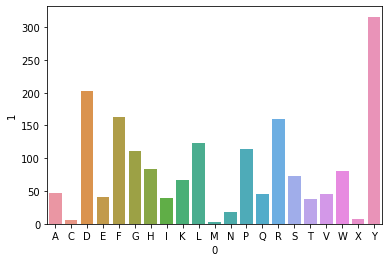

In [90]:
sorted_seed_seq_counts = {}
for key in sorted(seed_seq_counts):
    sorted_seed_seq_counts[key] = seed_seq_counts[key]

my_df = pd.DataFrame(sorted_seed_seq_counts.items())
sns.barplot(x=0, y=1, data=my_df)

In [88]:
seed_seqs = pd.read_csv('graph_generation/data/generated/generation2_seqs/top_seeds.csv')[['cdr3']]
seed_seq_counts = {}

for seq in seed_seqs.values:
    seq = seq[0]
    for char in seq:
        if char in seed_seq_counts:
            seed_seq_counts[char] += 1
        else:
            seed_seq_counts[char] =1

<AxesSubplot:xlabel='0', ylabel='1'>

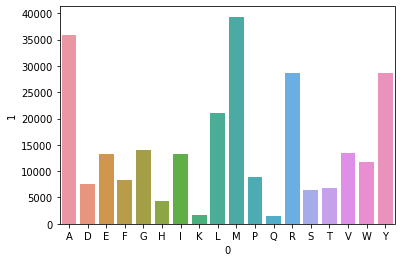

In [91]:
sorted_seq_counts = {}
for key in sorted(seq_counts):
    sorted_seq_counts[key] = seq_counts[key]

my_df = pd.DataFrame(sorted_seq_counts.items())
sns.barplot(x=0, y=1, data=my_df)

In [92]:
alphabet = 'ADEFGHIKLMPQRSTVWY'
seed_pos = np.zeros((18, 18))
for i, aa in enumerate(alphabet):
    for seq in seed_seqs['cdr3']:
        if aa in seq:
            seed_pos[i][seq.index(aa)] += 1

seed_freq = np.zeros((18, 18))
for i, aa in enumerate(seed_pos):
    total = sum(aa)
    for j, freq in enumerate(aa):
        seed_freq[i, j] = (freq/total) * 100

<AxesSubplot:>

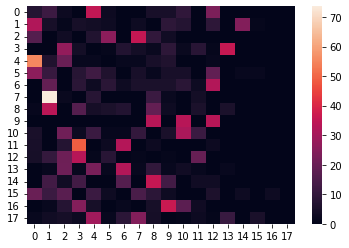

In [93]:
sns.heatmap(seed_freq)

In [95]:
alphabet = 'ADEFGHIKLMPQRSTVWY'
pos = np.zeros((18, 18))
for i, aa in enumerate(alphabet):
    for j, seq in enumerate(seqs['cdr3']):
        if aa in seq and seqs['perplexity'][j] < 7:
            pos[i][seq.index(aa)] += 1

pos_freq = np.zeros((18, 18))
for i, aa in enumerate(pos):
    total = sum(aa)
    for j, freq in enumerate(aa):
        pos_freq[i, j] = (freq/total) * 100

<AxesSubplot:>

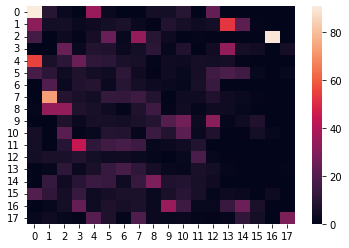

In [100]:
sns.heatmap(np.abs(pos_freq - seed_freq))